In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from tqdm import tqdm
from pprint import pprint
from src.cameras import *

# Geometrical Reconstruction
Use the extrinsics optimzed using BA and feed it to the geometrical reconstruction to track the 3D position of the marker.

In [3]:
cam_dm = cameraDataManager('sample_dataset/planar_ext_calib_dataset.pckl', 
                           'sample_dataset/intrinsics/',ports = [5002], data_idx= 3)  
synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=False)

In [4]:
with open('sample_dataset/ext_params_after_ba.pckl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['P1', 'P2', 'R', 't'])

In [5]:
P1, P2 = data['P1'], data['P2']
cam1_yaml = 'sample_dataset/intrinsics/5002_0.yaml'
cam2_yaml = 'sample_dataset/intrinsics/5002_1.yaml'

In [6]:
x1 = synchronized_pixels['5002-0']
x2 = synchronized_pixels['5002-1']
idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
idx = np.where(idx1*idx2)

x1 = x1[idx,...].squeeze()
x2 = x2[idx,...].squeeze()

In [7]:
stereoCamera = StereoCamera(cam1_yaml, cam2_yaml, P1, P2)
x1_undist, x2_undist = stereoCamera.undist(x1, x2)
landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
x1_proj, x2_proj = stereoCamera.reproject(landmarks)

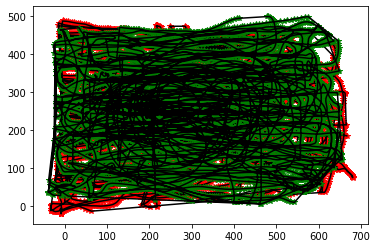

In [12]:
plt.plot(x1_proj[:,0], x1_proj[:,1],'r*')
plt.plot(x1_undist[:,0], x1_undist[:,1],'k')

plt.plot(x2_proj[:,0], x2_proj[:,1],'g*')
plt.plot(x2_undist[:,0], x2_undist[:,1],'k')

Histogram of the reprojection error using extrinsics obtained after BA


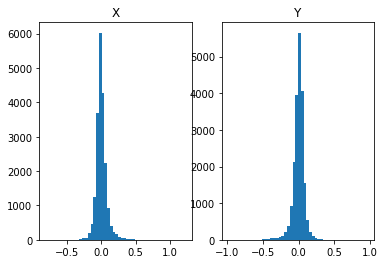

In [10]:
print('Histogram of the reprojection error using extrinsics obtained after BA')
ei = x1_proj[:,0:2] - x1_undist[:,0:2]
ej = x2_proj[:,0:2] - x2_undist[:,0:2]

ei = np.mean(ei, axis=-1)
ej = np.mean(ej, axis=-1)

fig,ax=plt.subplots(1,2)
_ = ax[0].hist(ei, bins=50)
_ = ax[0].set_title('X')
# plt.figure()
_ = ax[1].hist(ej, bins=50)
_ = ax[1].set_title('Y')